In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates as mpl_dates
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

In [2]:
ss=pd.read_csv("~/monthly-sunspots.csv")

In [3]:
ss.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [4]:
# Convert the 'Month' column to a datetime type
ss['Month'] = pd.to_datetime(ss['Month'])
                             
ss.set_index('Month', inplace=True)


In [5]:
ss.shape

(2820, 1)

In [6]:
ss

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


In [7]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2820 entries, 1749-01-01 to 1983-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  2820 non-null   float64
dtypes: float64(1)
memory usage: 44.1 KB


In [8]:
ss.isna().sum()

Sunspots    0
dtype: int64

In [9]:
ss.describe()

,Sunspots
count,2820.000000
mean,51.265957
std,43.448971
min,0.000000
25%,15.700000
50%,42.000000
75%,74.925000
max,253.800000


## Visualization of the data

In [10]:
#ss.plot()

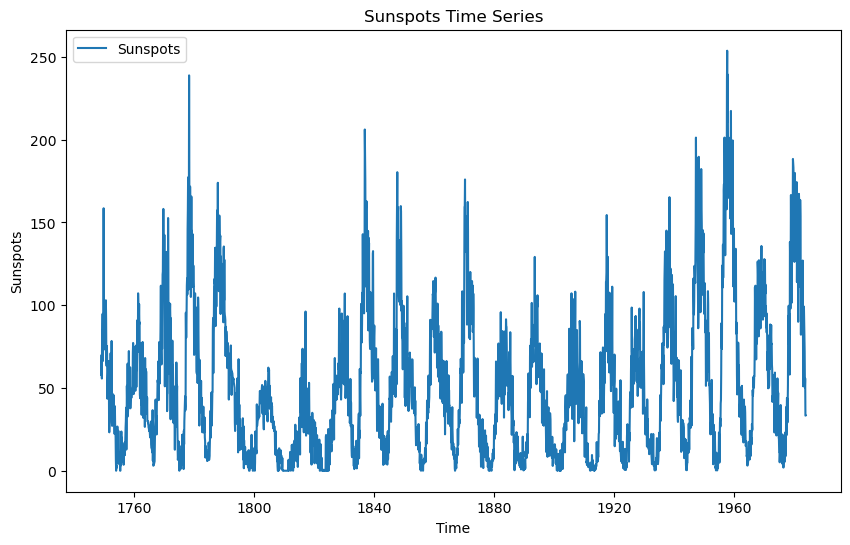

In [11]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(ss.index, ss['Sunspots'], label='Sunspots')
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("Sunspots Time Series")
plt.legend()

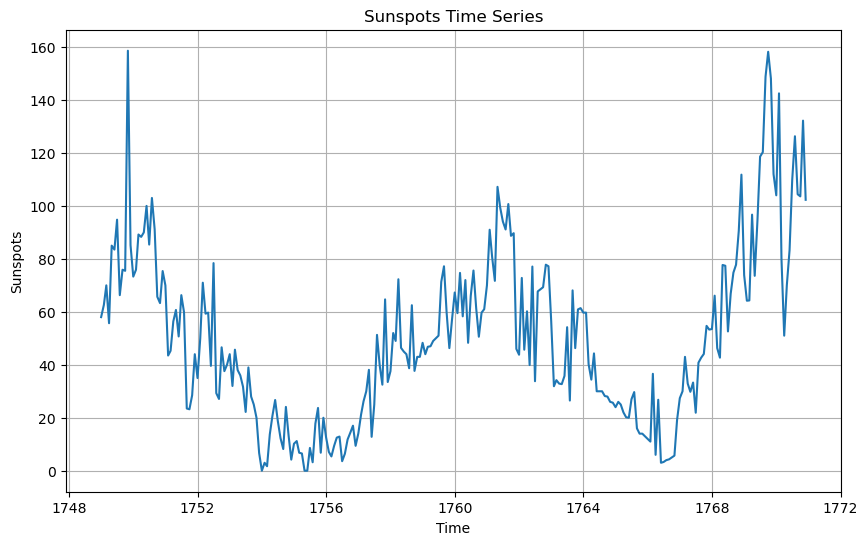

In [12]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(ss[0:264], label='Sunspots')  # looking at the first 22 years
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("Sunspots Time Series")
plt.grid(True)


#### Checking whether it is stationary or not

The null hypothesis of the ADF test is that the time series has a unit root (non-stationary). The ADF statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence. If the p-value is less than or equal to 0.05 (or any significance level you choose), we reject the null hypothesis and consider the time series to be stationary.

- If ADF Statistic < Critical Value: Reject the null hypothesis (consider the time series stationary).
- If ADF Statistic > Critical Value: Fail to reject the null hypothesis (consider the time series non-stationary).

In [13]:
# Perform the Augmented Dickey-Fuller (ADF) test
result = adfuller(ss['Sunspots'], autolag='AIC')

# Extract and print the test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]
num_lags=result[2]
num_obs=result[3]

print(f'No. of lags used: {num_lags}')
print(f'No. of Observations used: {num_obs}')
print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Check if the time series is stationary or not based on the p-value
if p_value <= 0.05:
    print("The time series is stationary (reject the null hypothesis of non-stationarity).")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis of non-stationarity).")


No. of lags used: 27
No. of Observations used: 2792
ADF Statistic: -9.567667511913081
P-value: 2.3334521438662545e-16
Critical Values:
   1%: -3.432694313168895
   5%: -2.862575752726396
   10%: -2.5673213632123297
The time series is stationary (reject the null hypothesis of non-stationarity).


## Autocorrelation and Partial Autocorrelation

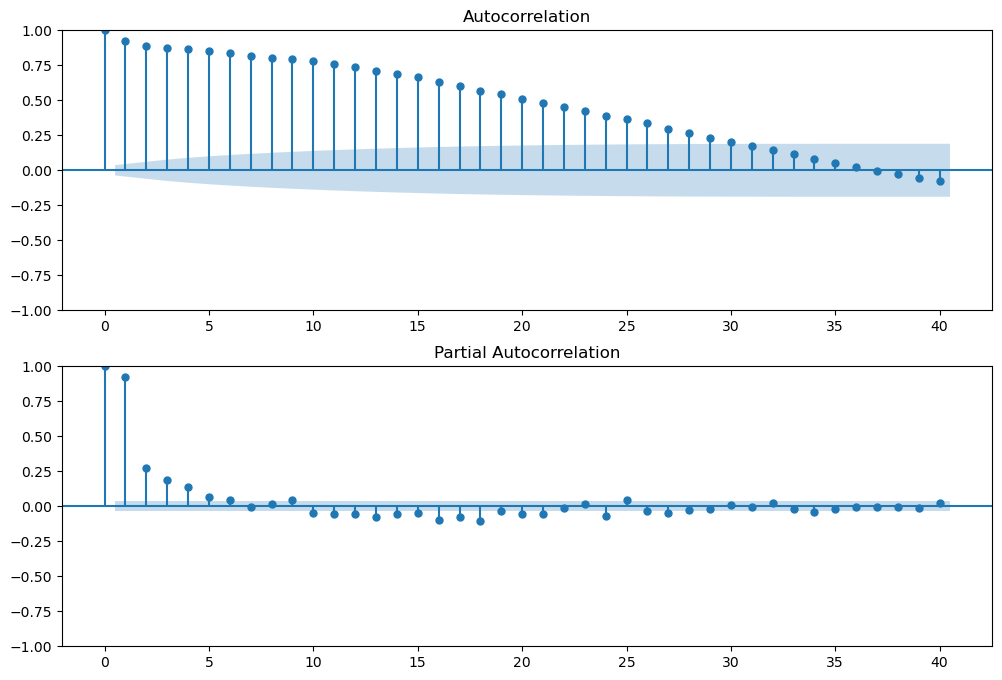

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ss['Sunspots'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ss['Sunspots'],lags=40,ax=ax2)

From ACF plot, present value depends on previous 26-30 value.
From PACF plot, present value depends on previous 5-6 value.

In [15]:
# Use auto_arima to find the best ARIMA model
model = auto_arima(ss['Sunspots'], seasonal=False, stationary=True ,trace=True, error_action='ignore', suppress_warnings=True)

# Get the optimal (p, d, q) values
optimal_p = model.order[0]
optimal_d = model.order[1]
optimal_q = model.order[2]

print(f"Optimal (p, d, q) values: ({optimal_p}, {optimal_d}, {optimal_q})")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=23563.381, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29277.565, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23939.774, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27004.219, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31735.779, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=23561.384, Time=0.63 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=25894.791, Time=0.75 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23598.132, Time=0.35 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=23563.378, Time=1.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=25315.543, Time=1.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=23564.748, Time=0.73 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=23564.250, Time=1.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23575.072, Time=0.18 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 7.707 seconds
Optimal (

In [16]:
df = ss.copy()

In [17]:
train_size = int(len(df) * 0.90)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# ARMA

In [18]:
#taking p,d,q=6,0,30 from observation

In [19]:
import time
start_time=time.time()
warnings.filterwarnings('ignore')

model1_arma=ARIMA(train,order=(6,0,30)).fit()

print('Time taken to run: ',time.time()-start_time)

Time taken to run:  136.52440285682678


In [21]:
model1_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 2538
Model:                ARIMA(6, 0, 30)   Log Likelihood              -10487.018
Date:                Thu, 03 Aug 2023   AIC                          21050.035
Time:                        00:51:57   BIC                          21271.922
Sample:                    01-01-1749   HQIC                         21130.529
                         - 06-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.1860      4.363     11.275      0.000      40.636      57.736
ar.L1          0.3075      0.305      1.007      0.314      -0.291       0.906
ar.L2          1.3299      0.215      6.194      0.000       0.909       1.751
ar.L3          0.4794      0.409      1.173      0.241      -0.322       1.281
ar.L4         -0.8149      0.439     -1.854      0.064      -1.676       0.046
ar.L5         -0.7631      0.201     -3.799      0.000      -1.157      -0.369
ar.L6          0.4536      0.307      1.476      0.140      -0.149       1.056
ma.L1          0.2211      0.305      0.725      0.468      -0.376       0.819
ma.L2         -1.1131      0.267     -4.168      0.000      -1.636      -0.590
ma.L3         -0.9657      0.303     -3.185      0.001      -1.560      -0.371
ma.L4          0.2891      0.439      0.659      0.510      -0.571       1.149
ma.L5          0.7880      0.225      3.499      0.000       0.347       1.229
ma.L6         -0.0972      0.186     -0.523      0.601      -0.461       0.267
ma.L7         -0.0726      0.069     -1.054      0.292      -0.208       0.062
ma.L8         -0.0580      0.035     -1.669      0.095      -0.126       0.010
ma.L9          0.1003      0.037      2.683      0.007       0.027       0.174
ma.L10         0.1138      0.039      2.886      0.004       0.037       0.191
ma.L11        -0.0143      0.056     -0.254      0.799      -0.125       0.096
ma.L12        -0.1136      0.045     -2.529      0.011      -0.202      -0.026
ma.L13        -0.0338      0.039     -0.862      0.388      -0.111       0.043
ma.L14         0.0494      0.040      1.221      0.222      -0.030       0.129
ma.L15         0.0383      0.033      1.177      0.239      -0.026       0.102
ma.L16        -0.0242      0.036     -0.678      0.498      -0.094       0.046
ma.L17        -0.0653      0.036     -1.793      0.073      -0.137       0.006
ma.L18        -0.0487      0.039     -1.235      0.217      -0.126       0.029
ma.L19         0.0278      0.047      0.587      0.557      -0.065       0.121
ma.L20         0.0520      0.036      1.452      0.146      -0.018       0.122
ma.L21        -0.0201      0.041     -0.495      0.621      -0.100       0.059
ma.L22        -0.0336      0.039     -0.854      0.393      -0.111       0.044
ma.L23         0.0830      0.038      2.184      0.029       0.008       0.157
ma.L24         0.0338      0.048      0.703      0.482      -0.060       0.128
ma.L25         0.0094      0.046      0.206      0.836      -0.080       0.099
ma.L26        -0.0119      0.040     -0.302      0.763      -0.089       0.066
ma.L27        -0.0463      0.040     -1.166      0.243      -0.124       0.032
ma.L28        -0.0563      0.032     -1.767      0.077      -0.119       0.006
ma.L29        -0.0310      0.026     -1.175      0.240      -0.083       0.021
ma.L30         0.0833      0.026      3.224      0.001       0.033       0.134
sigma2       226.7769      4.198     54.024      0.000     218.550     235.004
==

In [22]:
print(df.shape)
print(train.shape)
print(test.shape)
print(len(train))
print(len(train)+len(test)-1)

(2820, 1)
(2538, 1)
(282, 1)
2538
2819


<Axes: xlabel='Month'>

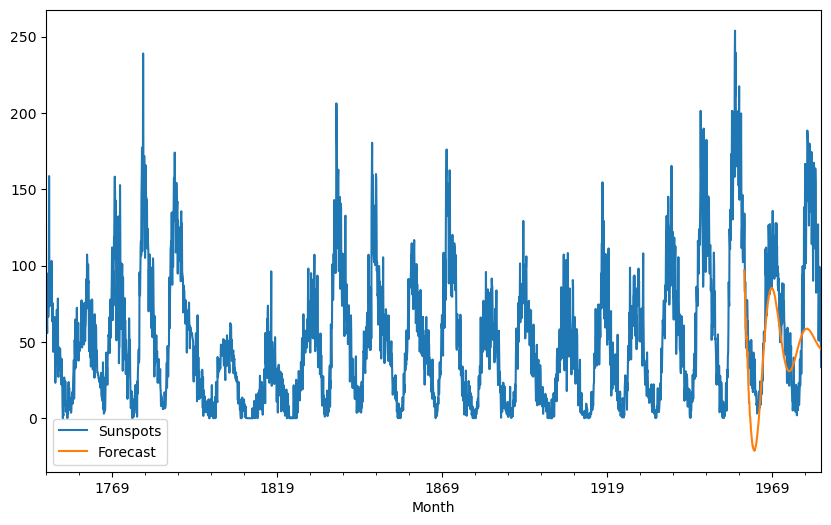

In [28]:
start_index = len(train)
end_index = len(train)+len(test)-1
df['Forecast']=model1_arma.predict(start=start_index,end=end_index,dynamic=True)
df[['Sunspots','Forecast']].plot(figsize=(10,6))

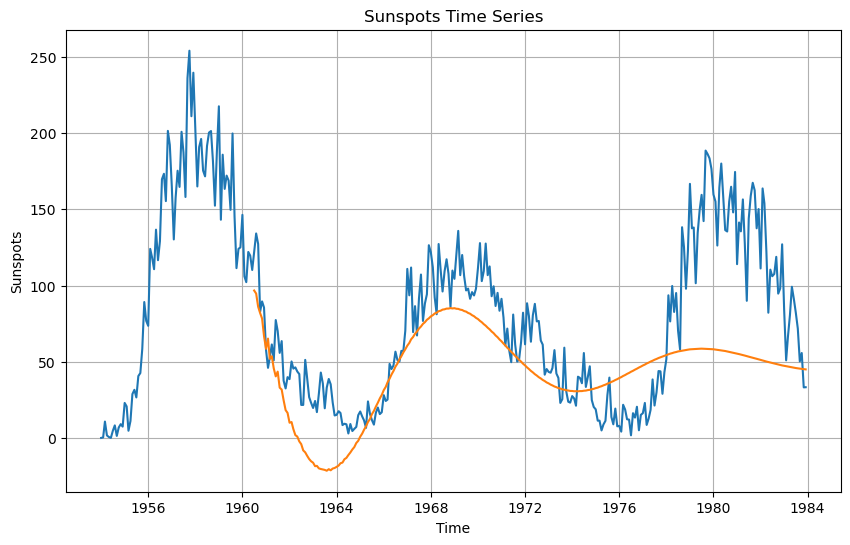

In [29]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[-360:], label='Sunspots')  # looking at the last 30 years(30*12) for better view
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("Sunspots Time Series")
plt.grid(True)

In [30]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,61)]  #taking next 5 years(60 months) data for test
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns) #making it as dataframe
future_df=pd.concat([df,future_datest_df]) #merging with original dataframe

In [31]:
df.tail(1)

,Sunspots,Forecast
Month,,
1983-12-01,33.4,45.074162


In [32]:
future_datest_df.head(1)

,Sunspots,Forecast
1984-01-01,NaN,NaN


In [81]:
#future_df

In [35]:
#future_df.index[2820]

In [83]:
#future_df.shape

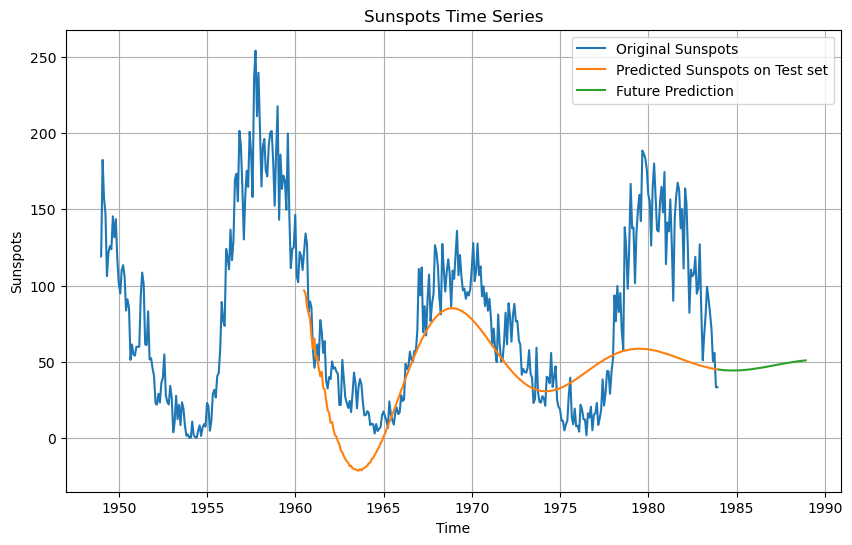

In [37]:
future_df['forecast'] = model1_arma.predict(start = 2820, end = 2879, dynamic= True)

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(future_df.iloc[-480:], label=['Original Sunspots','Predicted Sunspots on Test set', 'Future Prediction']) 
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("Sunspots Time Series")
plt.grid(True)
plt.legend()

In [79]:
#test['Sunspots']
# df['Forecast'].iloc[-282:]
#-(test.size)=-282

In [38]:
# Calculate the RMSE
rmse_arma = (mean_squared_error(test['Sunspots'], df['Forecast'].iloc[-(test.size):],squared=False))
print("RMSE:", rmse_arma)

RMSE: 45.20056680598236


In [39]:
#Using p,d,q=1,0,2 from auto arima

In [40]:
df2=ss.copy()
df2.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [41]:
warnings.filterwarnings('ignore')

model2_arma=ARIMA(train,order=(1,0,2)).fit()

<Axes: xlabel='Month'>

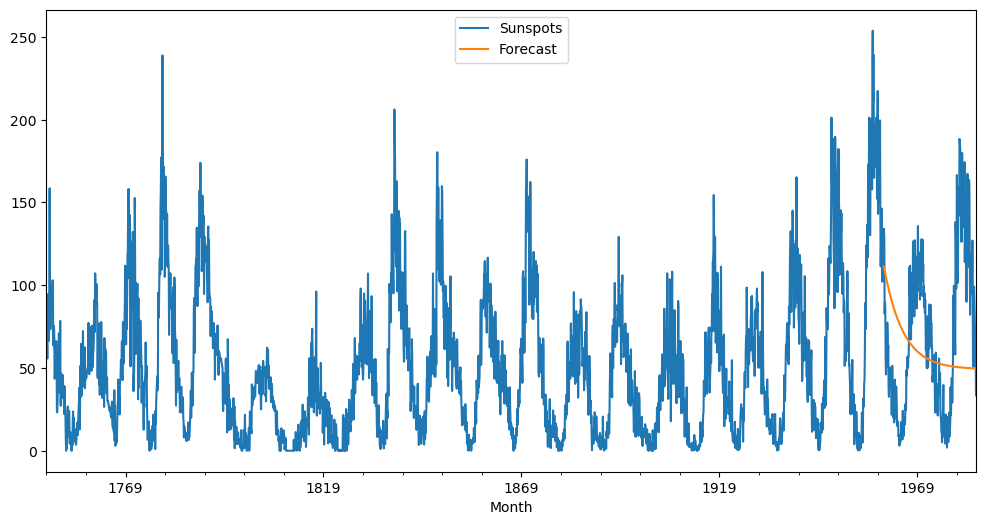

In [43]:
df2['Forecast']=model2_arma.predict(start=start_index,end=end_index,dynamic=True)
df2[['Sunspots','Forecast']].plot(figsize=(12,6))

In [44]:
future_dates2=[df2.index[-1]+ DateOffset(months=x)for x in range(0,61)]  #taking next 5 years(60 months) data for test
future_datest_df2=pd.DataFrame(index=future_dates2[1:],columns=df2.columns) #making it as dataframe
future_df2=pd.concat([df2,future_datest_df2]) #merging with original dataframe


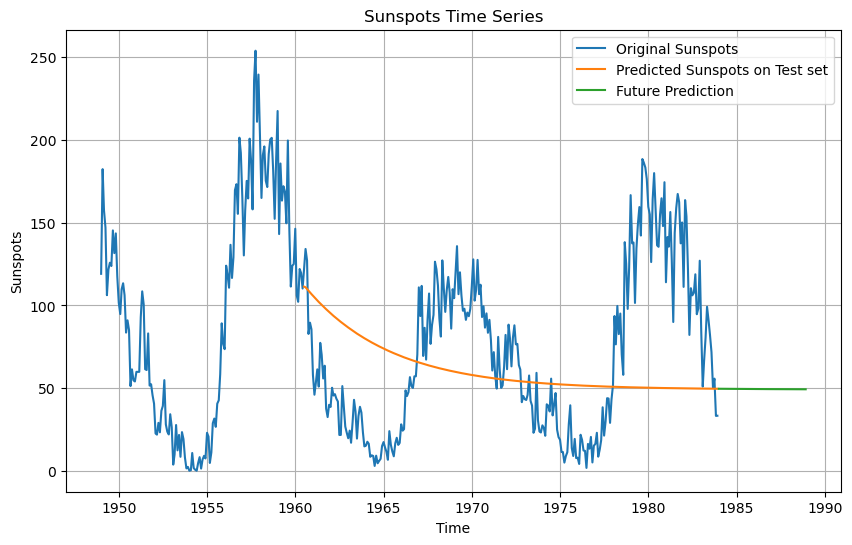

In [45]:
future_df2['forecast'] = model2_arma.predict(start = 2820, end = 2879, dynamic= True) 

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(future_df2.iloc[-480:], label=['Original Sunspots','Predicted Sunspots on Test set', 'Future Prediction']) 
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("Sunspots Time Series")
plt.grid(True)
plt.legend()

In [46]:
# Calculate the RMSE
rmse_arma2 = (mean_squared_error(test['Sunspots'], df2['Forecast'].iloc[-(test.size):],squared=False))
print("RMSE:", rmse_arma2)

RMSE: 54.48696748069437


In [47]:
#test['Sunspots']

In [48]:
#df2['Forecast'].iloc[-423:]

# AR 

In [50]:
# Fit the Autoregressive (AR) model on the training data
ar_model = AutoReg(train, lags=6).fit()

In [77]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 2538
Model:                     AutoReg(6)   Log Likelihood              -10552.566
Method:               Conditional MLE   S.D. of innovations             15.623
Date:                Thu, 03 Aug 2023   AIC                          21121.131
Time:                        03:22:07   BIC                          21167.825
Sample:                    07-01-1749   HQIC                         21138.072
                         - 06-01-1960                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7816      0.489      3.643      0.000       0.823       2.740
Sunspots.L1     0.5776      0.020     29.113      0.000       0.539       0.617
Sunspots.L2     0.1182      0.023      5.161      0.000       0.073       0.163
Sunspots.L3     0.0915      0.023      3.986      0.000       0.047       0.136
Sunspots.L4     0.0857      0.023      3.733      0.000       0.041       0.131
Sunspots.L5     0.0352      0.023      1.536      0.124      -0.010       0.080
Sunspots.L6     0.0561      0.020      2.823      0.005       0.017       0.095
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0180           -0.0000j            1.0180           -0.0000
AR.2            0.8710           -1.4447j            1.6870           -0.1637
AR.3            0.8710           +1.4447j            1.6870            0.1637
AR.4           -1.8087           -0.0000j            1.8087           -0.5000
AR.5           -0.7894           -1.6673j            1.8448           -0.3204
AR.6           -0.7894           +1.6673j            1.8448            0.3204
-----------------------------------------------------------------------------
"""

In [56]:
predictions = ar_model.predict(start=start_index,end=end_index,dynamic=True)

# Calculate RMSE
rmse_ar = mean_squared_error(test, predictions, squared=False)
rmse_ar

54.20386203159751

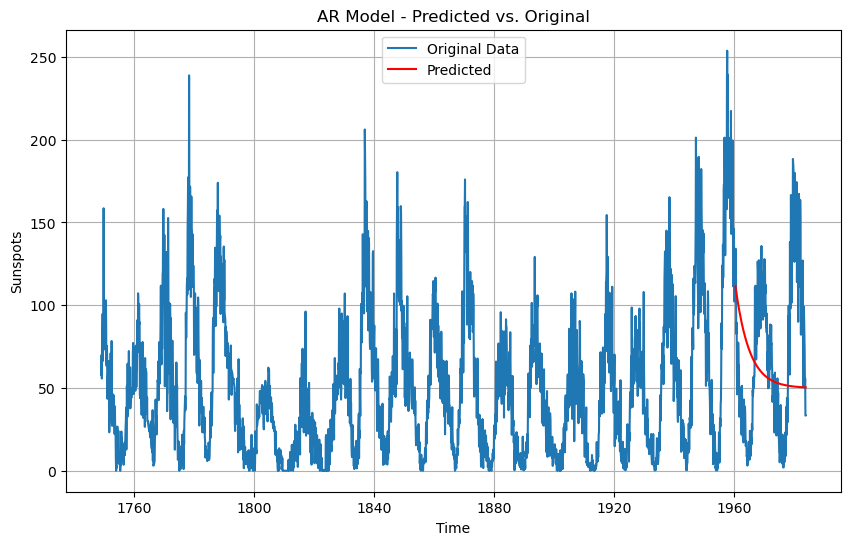

In [63]:
# Plot the predicted curve along with the dataset
plt.figure(figsize=(10, 6))
plt.plot(ss, label='Original Data')  
plt.plot(predictions, label='Predicted', color='red')  # Predicted values for the test set
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("AR Model - Predicted vs. Original")
plt.legend()
plt.grid(True)
plt.show()


As RMSE score for AR is more than ARMA model, I did not do future prediction.

# MA

In [62]:
ma_model = ARIMA(train, order=(0, 0, 30)).fit()

# Making predictions on the test set
ma_predictions = ma_model.predict(start=start_index,end=end_index,dynamic=True)

# Calculating the RMSE for the MA model
ma_rmse = mean_squared_error(test, ma_predictions, squared=False)
print("MA RMSE:", ma_rmse)


MA RMSE: 51.26156952134718


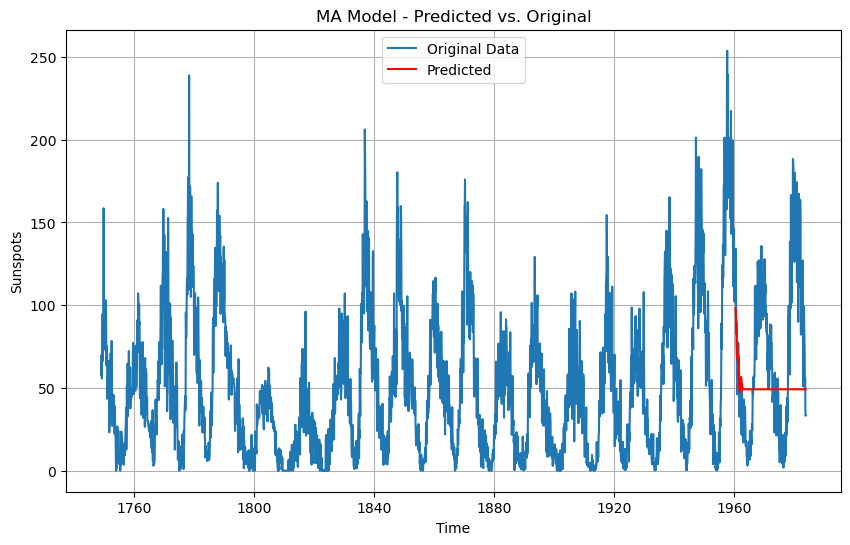

In [64]:
# Plot the predicted curve along with the dataset
plt.figure(figsize=(10, 6))
plt.plot(ss, label='Original Data')  
plt.plot(ma_predictions, label='Predicted', color='red')  # Predicted values for the test set
plt.xlabel("Time")
plt.ylabel("Sunspots")
plt.title("MA Model - Predicted vs. Original")
plt.legend()
plt.grid(True)
plt.show()

As RMSE score for MA is more than ARMA model, I did not do future prediction.

# Model Comparison

Since differenciation was not needed (d=0), the ARIMA model becomes equivalent to the ARMA model.

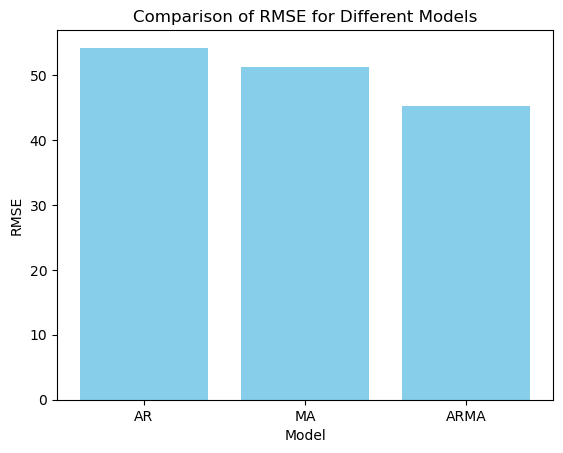

In [68]:
models = ['AR', 'MA', 'ARMA']
rmse_values = [rmse_ar, ma_rmse, rmse_arma]

# Plot RMSE values for different models
plt.bar(models, rmse_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.show()